<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/Burgers_Tensorflow_PINN_Jo%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
pip install --upgrade pyDOE

In [41]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Input, Dense
from time import time
from keras.optimizers import Adam
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [42]:
keras.backend.set_floatx('float32')
tf.random.set_seed(0)
pi = tf.constant(np.pi)
mi = 0.01/tf.constant(np.pi)
dados = loadmat('burgers_shock.mat')
x_dados = dados['x'].flatten()[:,None]
t_dados = dados['t'].flatten()[:,None]
u_dados = np.real(dados['usol']).T

T_dados, X_dados = np.meshgrid(x_dados, t_dados)
X_star = np.hstack((T_dados.flatten()[:,None], X_dados.flatten()[:,None]))
#Definindo as condições de contorno e inicial
def inicial(x):
  return -tf.sin(pi*x)

def contorno(t, x):
  n = x.shape[0]
  return tf.zeros((n,1))

#Definindo os pontos X
N_0 = 100 #100 pontos para condição inicial
N_b = 100 #100 pontos para condição de contorno
N_r = 10000 #Pontos para a edp

#Pontos do domínio, dado pelo Maziar
tmin = 0. ; tmax = 1.
xmin = -1.; xmax = 1.

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin]); ub = tf.constant([tmax, xmax])

#Obtendo pontos para a condição inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de -1 a 1
x0 = tf.concat([t0, x0], 1) #Criando uma matriz com os valores de tempo = 0 e de x0

#Valores de u para a condição inicial
u_ini = inicial(x0[:,1:2])

#Repetindo o processo, mas para a condição de contorno
tb = tf.random.uniform((N_b,1), lb[0], ub[0])
xb = lb[1] + (ub[1] - lb[1]) * keras.backend.random_bernoulli((N_b,1), 0.5)
xb = tf.concat([tb, xb], 1)

#Valores na condição de contorno
u_cont = contorno(xb[:,0:1], xb[:,1:2])

#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
xr = tf.concat([tr, xr], 1)

#Fazendo uma lista, para uso posterior
X_cond = [x0, xb]
u_cond = [u_ini, u_cont]

#Realizando plotagem dos pontos que são usados para condição de contorno, inicial e para edp

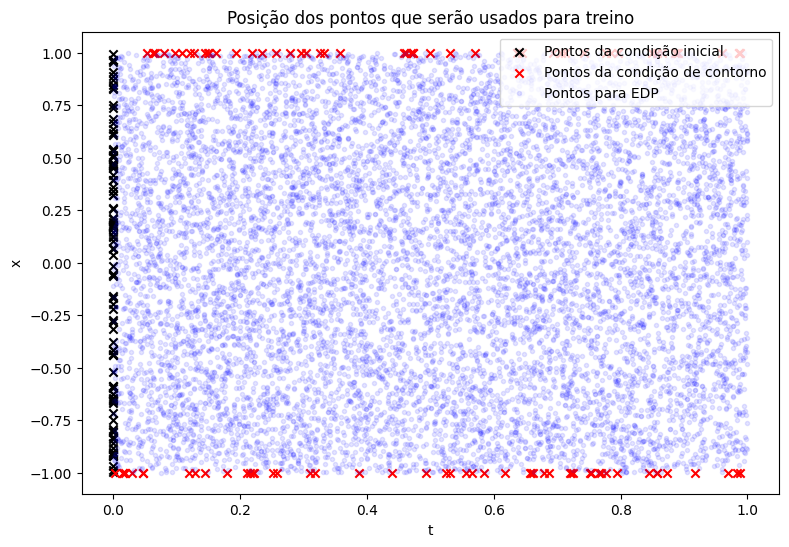

In [43]:
plt.figure(figsize=(9,6))
plt.scatter(x0[:,0:1],x0[:,1:2], c='black', marker ='x')
plt.scatter(xb[:,0:1],xb[:,1:2], c='red', marker ='x')
plt.scatter(xr[:,0:1], xr[:,1:2], c='blue', marker = '.', alpha = 0.1)
plt.xlabel('t'); plt.ylabel('x')
plt.title('Posição dos pontos que serão usados para treino')
plt.legend(['Pontos da condição inicial', 'Pontos da condição de contorno', 'Pontos para EDP'])
plt.show()

In [25]:
#Agora criando o modelo de Rede neural

def modelopinn(nos, camadas_ocultas):
  modelo = Sequential()
  #Inserindo o numero de variaveis de entrada
  modelo.add(Input(2))

  modelo.add(keras.layers.Lambda(
      lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
  ))
  for i in range(camadas_ocultas):
        modelo.add(Dense(nos, activation='tanh', kernel_initializer=GlorotNormal()))

  modelo.add(Dense(1))
  modelo.summary()
  return modelo

In [26]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:
    t, x = X_r[:, 0:1], X_r[:,1:2]
    tape.watch(t)
    tape.watch(x)
    u = modelo(tf.stack([t[:,0], x[:,0]], 1))

    ux = tape.gradient(u, x)

    ut = tape.gradient(u, t)
    uxx = tape.gradient(ux, x)

  del tape

  return ut + u*ux - mi*uxx

def MSE(modelo, xr, X_cond, u_cond):

    #Erro edp
    r = gradiente(modelo, xr)
    erro = tf.reduce_mean(tf.square(r))

    loss = erro

    #Erro da rede neural
    for i in range(len(X_cond)):
        u_pred = modelo(X_cond[i])
        loss += tf.reduce_mean(tf.square(u_cond[i] - u_pred))

    return erro, loss

def grad(modelo, xr, X_cond, u_cond):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro, loss = MSE(modelo, xr, X_cond, u_cond)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro, loss, g

In [27]:
modelo = modelopinn(20,8)

otimizador = Adam(learning_rate = 0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                4

In [28]:
@tf.function
def train_step(modelo):
  erro, loss, grad_theta = grad(modelo, xr, X_cond, u_cond)

  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro, loss

itr = 5000
historico = []
erro_aux = []
t0 = time()

for i in range(itr+1):

    erro, loss = train_step(modelo)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    erro_aux.append(erro.numpy)

    if i%10 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp: {:10.8e}".format(loss, erro))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

0 Loss treino: 4.65350658e-01, Loss edp: 1.62300258e-03
10 Loss treino: 4.15793568e-01, Loss edp: 4.48070746e-03
20 Loss treino: 3.95994723e-01, Loss edp: 2.89471983e-03
30 Loss treino: 3.70847940e-01, Loss edp: 9.35913622e-03
40 Loss treino: 3.27606440e-01, Loss edp: 2.56111454e-02
50 Loss treino: 2.47701317e-01, Loss edp: 3.21741551e-02
60 Loss treino: 1.94753811e-01, Loss edp: 6.11017756e-02
70 Loss treino: 1.80170521e-01, Loss edp: 6.79144040e-02
80 Loss treino: 1.70016348e-01, Loss edp: 4.78284806e-02
90 Loss treino: 1.60672456e-01, Loss edp: 5.92445172e-02
100 Loss treino: 1.55304685e-01, Loss edp: 5.39817512e-02
110 Loss treino: 1.51508048e-01, Loss edp: 5.48938103e-02
120 Loss treino: 1.49368808e-01, Loss edp: 5.28599620e-02
130 Loss treino: 1.46189809e-01, Loss edp: 5.29520810e-02
140 Loss treino: 1.43305331e-01, Loss edp: 5.15590198e-02
150 Loss treino: 1.40243500e-01, Loss edp: 5.10431565e-02
160 Loss treino: 1.36672080e-01, Loss edp: 4.97422591e-02
170 Loss treino: 1.326111

In [29]:
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)

U = upred.numpy().reshape(N+1,N+1)

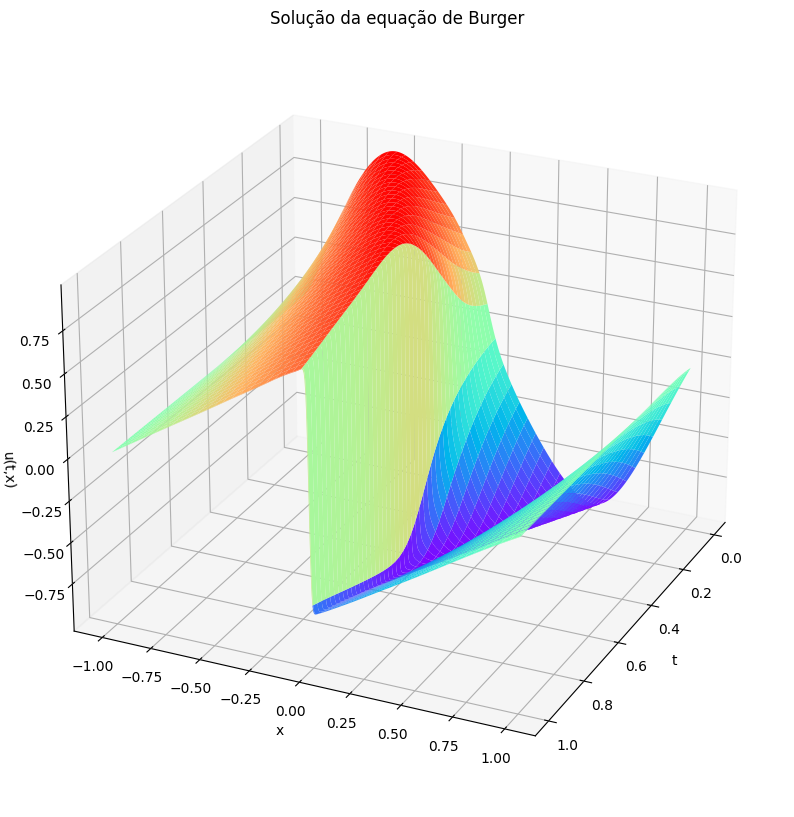

In [30]:
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='rainbow');
ax.view_init(25,25)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(t,x)')
ax.set_title('Solução da equação de Burger');
plt.show()

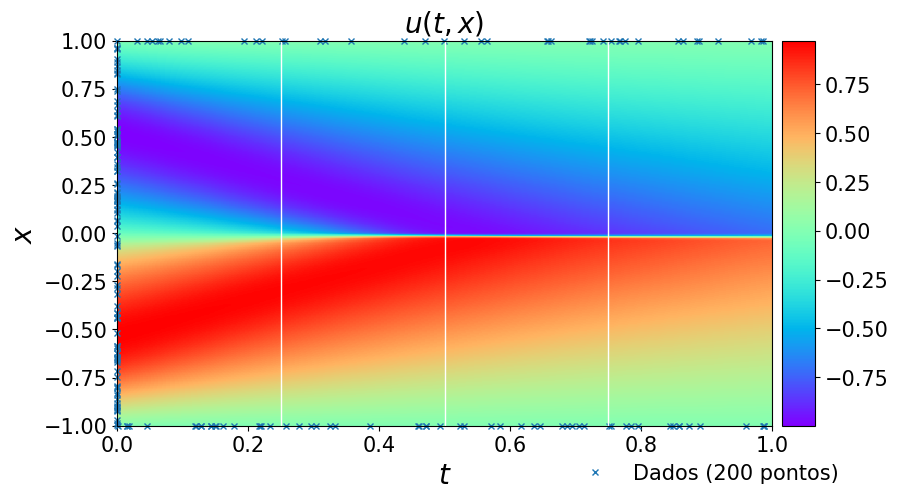

In [31]:
X_aux = np.vstack([x0,xb])
u_aux = np.vstack([u_ini,u_cont])
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U, interpolation='nearest', cmap='rainbow',
              extent=[tmin, tmax, xmin, xmax],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    X_aux[:,0],
    X_aux[:,1],
    'x', label = 'Dados (%d pontos)' % (u_aux.shape[0]),
    markersize = 4,
    clip_on = False,
    alpha=1.0
)

line = np.linspace(xmin, xmax, 2)[:,None]
ax.plot(tspace[150]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(tspace[300]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(tspace[450]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20)
ax.tick_params(labelsize=15)

plt.show()

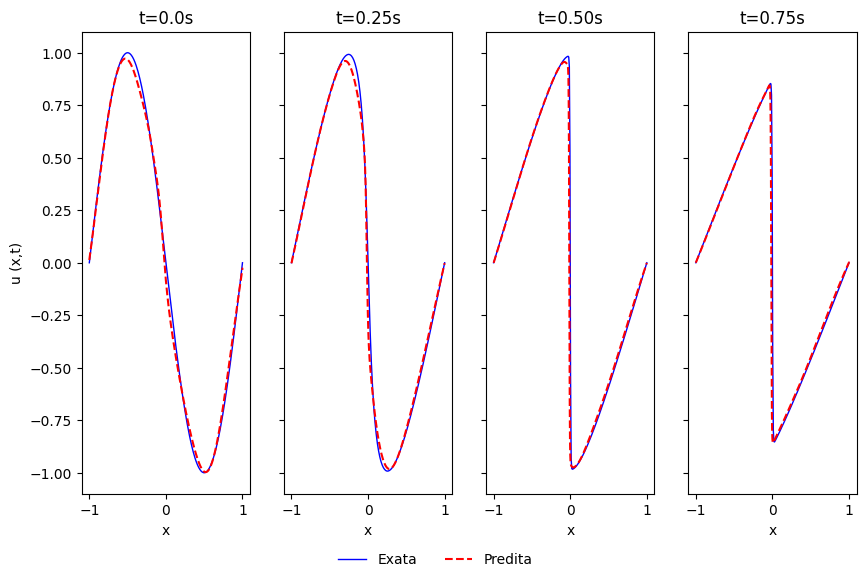

In [32]:
N = 600
xspace = np.linspace(lb[1], ub[1], N + 1)

t_ini = np.zeros((N+1))
T, X = np.meshgrid(t_ini, xspace)
X0 = np.vstack([T.flatten(),X.flatten()]).T

t_025 = np.ones((N+1))*0.25
T, X = np.meshgrid(t_025, xspace)
X025 = np.vstack([T.flatten(),X.flatten()]).T

t_050 = np.ones((N+1))*0.50
T, X = np.meshgrid(t_050, xspace)
X050 = np.vstack([T.flatten(),X.flatten()]).T

t_075 = np.ones((N+1))*0.75
T, X = np.meshgrid(t_075, xspace)
X075 = np.vstack([T.flatten(),X.flatten()]).T

fig, axs = plt.subplots(1, 4, figsize=(10,6) ,sharey=True)

axs[0].plot(x_dados,u_dados[0,:], 'b-', linewidth = 1, label = 'Exata')
axs[0].plot(X0[:,1], modelo(X0).numpy(), linestyle ='dashed', color='r', label = 'Predita')
axs[0].set_title('t=0.0s')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u (x,t)')

axs[1].plot(x_dados,u_dados[25,:], 'b-', linewidth = 1, label = 'Exata')
axs[1].plot(X025[:,1], modelo(X025).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[1].set_title('t=0.25s')
axs[1].set_xlabel('x')

axs[2].plot(x_dados,u_dados[50,:], 'b-', linewidth = 1, label = 'Exata')
axs[2].plot(X050[:,1], modelo(X050).numpy(),linestyle='dashed', color='r', label = 'Predita')
axs[2].set_title('t=0.50s')
axs[2].set_xlabel('x')

axs[3].plot(x_dados,u_dados[75,:], 'b-', linewidth = 1, label = 'Exata')
axs[3].plot(X075[:,1], modelo(X075).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[3].set_title('t=0.75s')
axs[3].set_xlabel('x')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(-1.5, -0.10),
    ncol=5,
    frameon=False
)
plt.show()

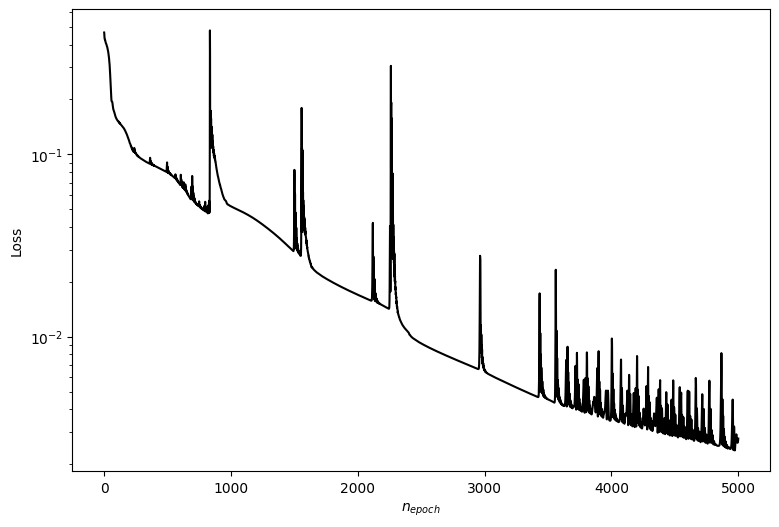

In [33]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(historico)), historico,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Loss');
plt.show()